<a href="https://colab.research.google.com/github/Adchayakumar/Mini_project_04/blob/main/clustering_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv("swiggy_data.csv")
df.dropna(subset=['name'], inplace=True)
df.drop(['id','lic_no'],axis=1,inplace=True)
df['cuisine']=df['cuisine'].fillna(df['cuisine'].mode()[0])

df['cost'] = pd.to_numeric(df['cost'].str.replace('₹', '', regex=False))

df['rating_cleaned']=pd.to_numeric(df['rating'],errors='coerce')

def clean_city(value):
    if pd.isnull(value):
        return value
    if ',' in value:
        return value.split(',')[-1].strip().title()
    return value.strip().title()

df['city_cleaned'] = df['city'].apply(clean_city)

def clean_cuisine(value):
    if pd.isnull(value):
        return []
    cuisines = [c.strip().title() for c in value.split(',')]
    cuisines = list(set(cuisines))  # remove duplicates
    cuisines.sort()  # keep consistent order
    return cuisines

df['cuisine_cleaned'] = df['cuisine'].apply(clean_cuisine)



In [ ]:
df.columns

Index(['name', 'city', 'rating', 'rating_count', 'cost', 'cuisine', 'link',
       'address', 'menu', 'rating_cleaned', 'city_cleaned', 'cuisine_cleaned'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
name,0
city,0
rating,0
rating_count,0
cost,45
cuisine,0
link,0
address,0
menu,0
rating_cleaned,87014


In [ ]:
# prompt: fill the nan value in the cost column with median

df['cost'].fillna(df['cost'].median(), inplace=True)

/tmp/ipython-input-4-1976180423.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cost'].fillna(df['cost'].median(), inplace=True)


In [ ]:
# prompt: fill na in rating column using median

df['rating_cleaned'].fillna(df['rating_cleaned'].median(), inplace=True)

/tmp/ipython-input-5-2005825070.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating_cleaned'].fillna(df['rating_cleaned'].median(), inplace=True)


In [ ]:
# prompt: using the iqr method handle the outlier in cost column

Q1 = df['cost'].quantile(0.25)
Q3 = df['cost'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping the outliers
df['cost'] = df['cost'].clip(lower=lower_bound, upper=upper_bound)


In [ ]:
df['rating_count'].value_counts()

,count
rating_count,
Too Few Ratings,87014
20+ ratings,21636
100+ ratings,20548
50+ ratings,12009
500+ ratings,4396
1K+ ratings,2739
5K+ ratings,98
10K+ ratings,15


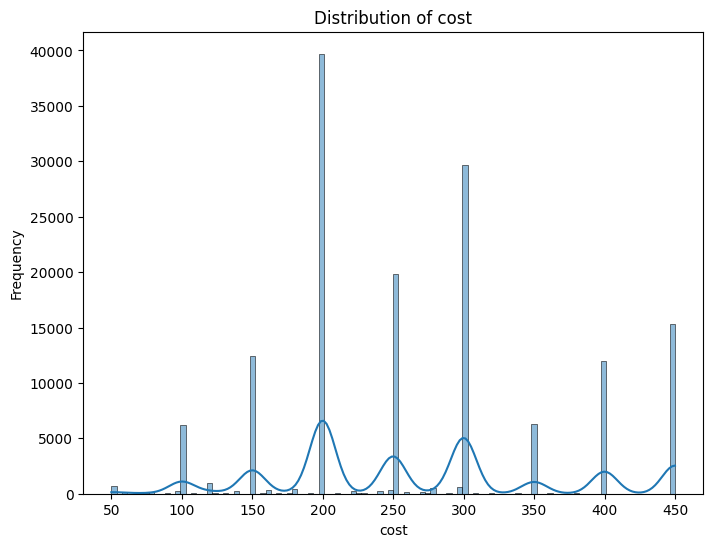

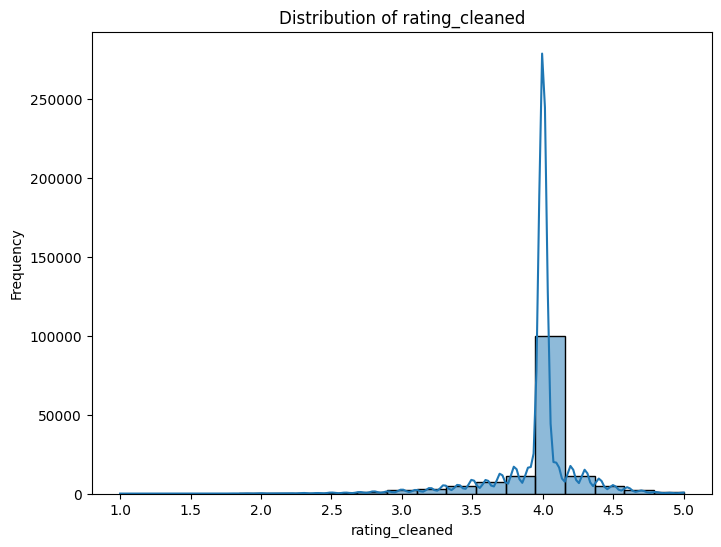

In [ ]:
# prompt: plot the distribution of all numeric column

import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Plot distributions for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
cluster_df=df.copy()
cluster_df.columns

Index(['name', 'city', 'rating', 'rating_count', 'cost', 'cuisine', 'link',
       'address', 'menu', 'rating_cleaned', 'city_cleaned', 'cuisine_cleaned'],
      dtype='object')

In [ ]:
cluster_df.drop(['rating','city','cuisine','link','address','menu','name','city_cleaned'],axis=1,inplace=True)

In [ ]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148455 entries, 0 to 148540
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rating_count     148455 non-null  object 
 1   cost             148455 non-null  float64
 2   rating_cleaned   148455 non-null  float64
 3   cuisine_cleaned  148455 non-null  object 
dtypes: float64(2), object(2)
memory usage: 5.7+ MB


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder




# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Step 3: Fit and transform the 'rating_count' column
encoded_array = encoder.fit_transform(cluster_df[['rating_count']])

# Step 4: Convert encoded result to a DataFrame
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(['rating_count'])
)

# Step 5: Reset index before joining (important!)
cluster_df = cluster_df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Step 6: Combine original DataFrame with encoded features (optional: drop original)
final_df = cluster_df.drop(columns=['rating_count']).join(encoded_df)

# Final result
print(final_df)


         cost  rating_cleaned                cuisine_cleaned  \
0       200.0             4.0            [Beverages, Pizzas]   
1       200.0             4.4               [Bakery, Sweets]   
2       100.0             3.8                    [Beverages]   
3       250.0             3.7            [Fast Food, Indian]   
4       250.0             4.0  [Fast Food, Italian-American]   
...       ...             ...                            ...   
148450  200.0             4.0            [Fast Food, Snacks]   
148451  300.0             4.0                       [Pizzas]   
148452  300.0             4.0            [Fast Food, Snacks]   
148453  250.0             4.0                  [Continental]   
148454  200.0             4.0                       [Pizzas]   

        rating_count_100+ ratings  rating_count_10K+ ratings  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             1.0      

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Initialize the encoder
mlb = MultiLabelBinarizer()

# Step 2: Fit and transform the cuisine_cleaned column
encoded_cuisine = mlb.fit_transform(cluster_df['cuisine_cleaned'])

# Step 3: Convert to DataFrame with column names
encoded_cuisine_df = pd.DataFrame(
    encoded_cuisine,
    columns=mlb.classes_
)

# Step 4: Reset index to align properly
cluster_df = cluster_df.reset_index(drop=True)
encoded_cuisine_df = encoded_cuisine_df.reset_index(drop=True)

# Step 5: Join with cluster_df
cluster_df = cluster_df.join(encoded_cuisine_df)


In [ ]:
# Step 1: Drop the rating_count column from cluster_df
cluster_df = cluster_df.drop(columns=['rating_count'])

# Step 2: Join rating_count one-hot encodings from final_df
cluster_df = cluster_df.join(final_df.filter(like='rating_count_'))


In [ ]:
cluster_df.drop('cuisine_cleaned',axis=1,inplace=True)

In [ ]:
cluster_df.head()

,cost,rating_cleaned,8:15 To 11:30 Pm,Afghani,African,American,Andhra,Arabian,Asian,Assamese,...,Vietnamese,Waffle,rating_count_100+ ratings,rating_count_10K+ ratings,rating_count_1K+ ratings,rating_count_20+ ratings,rating_count_50+ ratings,rating_count_500+ ratings,rating_count_5K+ ratings,rating_count_Too Few Ratings
0,200.0,4.0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,200.0,4.4,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,100.0,3.8,0,0,0,0,0,0,0,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,250.0,3.7,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,250.0,4.0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
cluster_df['cost_scaled'] = scaler.fit_transform(cluster_df[['cost']])


In [ ]:
cluster_df.drop('cost',axis=1,inplace=True)

In [ ]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148455 entries, 0 to 148454
Columns: 135 entries, rating_cleaned to cost_scaled
dtypes: float64(10), int64(125)
memory usage: 152.9 MB


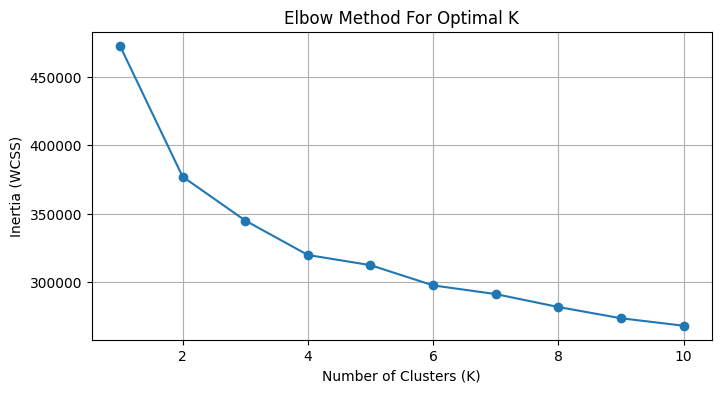

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ✅ Step 1: Select only numeric columns (features for clustering)
# This excludes columns like restaurant names, original cuisine etc.
features = cluster_df.select_dtypes(include=['float64', 'int64'])


# ✅ Step 2: Use the Elbow method to find optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# ✅ Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# 1. Select only numeric columns for clustering
features = cluster_df.select_dtypes(include=['float64', 'int64'])

# 2. Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(features)


In [ ]:
df['cluster'] = cluster_df['cluster'].values
df.to_csv("final_clustered_restaurants.csv", index=False)

In [ ]:
import pandas as pd
df=pd.read_csv("final_clustered_restaurants.csv")

In [ ]:
# prompt: change the column name rating_cleaned into rating, cuisine cleaned into cuisine

df.rename(columns={'rating_cleaned': 'rating', 'cuisine_cleaned': 'cuisine','city_cleaned':'city'}, inplace=True)

In [ ]:
df.head()

,name,rating_count,cost,link,address,menu,rating,city,cuisine,cluster
0,AB FOODS POINT,Too Few Ratings,200.0,https://www.swiggy.com/restaurants/ab-foods-po...,"AB FOODS POINT, NEAR RISHI NARANG DENTAL CLINI...",Menu/567335.json,4.0,Abohar,"['Beverages', 'Pizzas']",0
1,Janta Sweet House,50+ ratings,200.0,https://www.swiggy.com/restaurants/janta-sweet...,"Janta Sweet House, Bazar No.9, Circullar Road,...",Menu/531342.json,4.4,Abohar,"['Bakery', 'Sweets']",3
2,theka coffee desi,100+ ratings,100.0,https://www.swiggy.com/restaurants/theka-coffe...,"theka coffee desi, sahtiya sadan road city",Menu/158203.json,3.8,Abohar,['Beverages'],3
3,Singh Hut,20+ ratings,250.0,https://www.swiggy.com/restaurants/singh-hut-n...,"Singh Hut, CIRCULAR ROAD NEAR NEHRU PARK ABOHAR",Menu/187912.json,3.7,Abohar,"['Fast Food', 'Indian']",3
4,GRILL MASTERS,Too Few Ratings,250.0,https://www.swiggy.com/restaurants/grill-maste...,"GRILL MASTERS, ADA Heights, Abohar - Hanumanga...",Menu/543530.json,4.0,Abohar,"['Fast Food', 'Italian-American']",2


In [ ]:
# prompt: drop the city, rating, cuisine column

df.drop(['city', 'rating', 'cuisine'], axis=1, inplace=True)


In [ ]:
# prompt: save the csv with swiggy_restaurants_clustered.csv this name

df.to_csv("swiggy_restaurants_clustered.csv", index=False)

In [ ]:
# prompt: remove the ratings text in rating_count column

df['rating_count'] = df['rating_count'].astype(str).str.replace(' ratings', '').str.replace(' rating', '')